<a href="https://colab.research.google.com/github/Ajinkya-18/NeuroVision/blob/main/inference_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
os.makedirs('/content/final_lightweight_17k', exist_ok=True)

In [2]:
!cp /content/drive/MyDrive/NeuroVision/alljoined_lightweight_17k.tar.gz /content/

In [3]:
!tar -xzf /content/alljoined_lightweight_17k.tar.gz -C /content/final_lightweight_17k

In [4]:
import torch
from pathlib import Path
from tqdm.auto import tqdm

# Path to your lightweight dataset on the local Colab disk
DATA_ROOT = '/content/final_lightweight_17k'
SPECTROGRAM_TRAIN_DIR = Path(DATA_ROOT) / 'spectrograms' / 'train'

# Initialize accumulators
channel_sum = torch.zeros(64, dtype=torch.float64)
channel_sum_sq = torch.zeros(64, dtype=torch.float64)
pixel_count = 0

# Calculate stats only on the training set
files = list(SPECTROGRAM_TRAIN_DIR.glob('*.pt'))
for path in tqdm(files, desc="Calculating Spectrogram Stats"):
    data = torch.load(path)
    channel_sum += data.sum(dim=[1, 2]).to(torch.float64)
    channel_sum_sq += (data.to(torch.float64) ** 2).sum(dim=[1, 2])
    pixel_count += data.shape[1] * data.shape[2]

mean = (channel_sum / pixel_count).to(torch.float32)
std = torch.sqrt((channel_sum_sq / pixel_count) - mean.to(torch.float64)**2).to(torch.float32)

# Save the stats to the dataset folder
torch.save(mean, Path(DATA_ROOT) / 'spec_mean.pt')
torch.save(std, Path(DATA_ROOT) / 'spec_std.pt')

print(f"\nStats calculated and saved to {DATA_ROOT}")

Calculating Spectrogram Stats:   0%|          | 0/14000 [00:00<?, ?it/s]


Stats calculated and saved to /content/final_lightweight_17k


In [1]:
print("⏳ Installing and upgrading libraries...")
# The -q flag makes the output cleaner
!pip install torchvision timm accelerate open-clip-torch torch diffusers==0.33.0 transformers==4.54.0
# !pip install peft ftfy regex tqdm evaluate jiwer rouge_score sentence-transformers
# !pip install git+https://github.com/openai/CLIP.git
!apt-get install -y fonts-liberation

⏳ Installing and upgrading libraries...
  Using cached open_clip_torch-3.2.0-py3-none-any.whl.metadata (32 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.35.1
    Uninstalling diffusers-0.35.1:
      Successfully uninstalled diffusers-0.35.1
  Attempting uninstall: transformers
    Found existing installation: transformer

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Inference Scripts

## Architecture Components

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from PIL import Image
from tqdm.auto import tqdm
import numpy as np
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from sentence_transformers import SentenceTransformer
import json
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import textwrap
from datetime import datetime

In [2]:
class EEGTransformerEncoder(nn.Module):
    """
    A powerful hybrid CNN-Transformer encoder to extract rich features
    directly from 64-channel EEG spectrograms.
    """
    def __init__(self, in_chans=64, embed_dim=768, nhead=8, num_layers=4, dropout=0.3):
        super().__init__()

        # 1. Convolutional Stem: Extracts local spatio-temporal features
        self.conv_stem = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim // 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(embed_dim // 4),
            nn.ELU(),
            nn.Conv2d(embed_dim // 4, embed_dim // 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(embed_dim // 2),
            nn.ELU(),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(embed_dim),
        )

        # 2. Transformer Encoder: Learns global relationships between features
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Input x: [Batch, 64, Freq, Time]

        # Pass through convolutional stem
        x = self.conv_stem(x)
        # Output x: [Batch, embed_dim, F/4, T/4]

        # Prepare for transformer: flatten spatial dims and permute
        b, c, h, w = x.shape
        x = x.flatten(2).permute(0, 2, 1) # -> [Batch, H*W, embed_dim]

        # Pass through transformer encoder
        x = self.transformer_encoder(x)

        # Apply final layer normalization
        x = self.output_layernorm(x)

        return x

# ==============================================================================
# --- 3. THE HYBRID EEG-BLIP2 MODEL ---
# ==============================================================================
class EEG_BLIP2_Model(nn.Module):
    """
    The final, refactored model that directly connects a powerful EEG encoder
    to the BLIP-2 Q-Former via a projection layer.
    """
    def __init__(self, config, device, eeg_embed_dim=768):
        super().__init__()
        self.device = device

        # 1. Instantiate the powerful, from-scratch EEG encoder
        self.eeg_encoder = EEGTransformerEncoder(embed_dim=eeg_embed_dim)

        # 2. Load the pre-trained BLIP model
        self.blip = Blip2ForConditionalGeneration.from_pretrained(config.BLIP_MODEL_NAME)

        # 3. Create the crucial projection layer
        # This layer maps the EEG encoder's output dimension (e.g., 768) to the
        # dimension the BLIP vision encoder's features, which the Q-Former expects (1408).
        blip_vision_hidden_size = self.blip.vision_model.config.hidden_size
        self.eeg_projection = nn.Linear(eeg_embed_dim, blip_vision_hidden_size)

        # The __init__ method no longer handles freezing. This is now controlled by the training loop.

        self.eeg_encoder.to(device)
        self.eeg_projection.to(device)
        self.blip.to(device)

    def get_eeg_embedding(self, eeg_spectrograms):
        """ The direct EEG-to-Q-Former forward pass. """
        # 1. Get rich features from our custom EEG encoder
        eeg_features = self.eeg_encoder(eeg_spectrograms)
        # Output shape: [Batch, SeqLen, 768]

        # 2. Project EEG features to match the Q-Former's expected input dimension
        projected_eeg_features = self.eeg_projection(eeg_features)
        # Output shape: [Batch, SeqLen, 1408]

        # 3. Pass projected features directly to the Q-Former
        query_tokens = self.blip.query_tokens.expand(projected_eeg_features.shape[0], -1, -1)
        query_outputs = self.blip.qformer(
            query_embeds=query_tokens,
            encoder_hidden_states=projected_eeg_features,
            return_dict=True,
        )
        return query_outputs.last_hidden_state.mean(dim=1)

    def get_image_embedding(self, pil_images, processor):
        # This function remains the same, using the standard image pathway
        inputs = processor(images=pil_images, return_tensors="pt").to(self.device)
        pixel_values = inputs.pixel_values
        image_features = self.blip.vision_model(pixel_values).last_hidden_state
        query_tokens = self.blip.query_tokens.expand(image_features.shape[0], -1, -1)
        query_outputs = self.blip.qformer(
            query_embeds=query_tokens,
            encoder_hidden_states=image_features,
            return_dict=True,
        )
        return query_outputs.last_hidden_state.mean(dim=1)

    def generate(self, eeg_spectrograms, **kwargs):
        with torch.no_grad():
            # Follow the same direct pathway for generation
            eeg_features = self.eeg_encoder(eeg_spectrograms)
            projected_eeg_features = self.eeg_projection(eeg_features)

            query_tokens = self.blip.query_tokens.expand(projected_eeg_features.shape[0], -1, -1)
            query_outputs = self.blip.qformer(
                query_embeds=query_tokens,
                encoder_hidden_states=projected_eeg_features,
                return_dict=True,
            )
            language_model_inputs = self.blip.language_projection(query_outputs.last_hidden_state)
            generated_ids = self.blip.language_model.generate(
                inputs_embeds=language_model_inputs,
                **kwargs
            )
            return generated_ids

    def forward(self, eeg_spectrograms):
        """
        Returns the EEG embedding and the raw logits from the language model.
        """
        # 1. Get EEG features and project them
        eeg_features = self.eeg_encoder(eeg_spectrograms)
        projected_eeg_features = self.eeg_projection(eeg_features)

        # 2. Get the 32 query embeddings from the Q-Former
        query_tokens = self.blip.query_tokens.expand(projected_eeg_features.shape[0], -1, -1)
        query_outputs = self.blip.qformer(
            query_embeds=query_tokens,
            encoder_hidden_states=projected_eeg_features,
            return_dict=True,
        )

        # 3. Project queries for the language model
        language_model_inputs = self.blip.language_projection(query_outputs.last_hidden_state)

        # 4. Get the logits from the language model
        outputs = self.blip.language_model(inputs_embeds=language_model_inputs, return_dict=True)
        logits = outputs.logits

        # Get the final EEG embedding for our alignment loss
        eeg_embedding = query_outputs.last_hidden_state.mean(dim=1)

        return eeg_embedding, logits


## Inference Script without Original Image Plotting

In [3]:
# ==============================================================================
# --- CONFIGURATION ---
# ==============================================================================
class INFERENCE_CONFIG:
    ### --- REQUIRED: UPDATE THIS PATH --- ###
    # Point this to the best .pth file from your last training run
    BEST_MODEL_PATH = '/content/drive/MyDrive/NeuroVision/EEG_BLIP2_Alignment/run_20251002_171100/best_model_epoch_28_loss_16.4225.pth'

    # --- Dataset and Model Paths ---
    PROCESSED_DATA_ROOT = '/content/final_lightweight_17k'
    METADATA_CSV = Path(PROCESSED_DATA_ROOT) / 'metadata.csv'
    BLIP_MODEL_NAME = "Salesforce/blip2-opt-2.7b"
    DIFFUSION_MODEL_ID = "runwayml/stable-diffusion-v1-5"

    # --- Inference Hyperparameters ---
    BATCH_SIZE = 4  # How many images to generate (e.g., 4 for a 2x2 grid)
    OUTPUT_DIR = '/content'

# ==============================================================================
# --- 3. DATASET FOR INFERENCE ---
# ==============================================================================
class EEGInferenceDataset(Dataset):
    def __init__(self, root_dir, metadata_csv, transform):
        self.root_dir = Path(root_dir)
        self.transform = transform
        df = pd.read_csv(metadata_csv)
        # We only want to test on the 'test' split
        self.split_df = df[df['split'].str.strip() == 'test'].reset_index(drop=True)
        print(f"Found {len(self.split_df)} samples in the test set.")

    def __len__(self):
        return len(self.split_df)

    def __getitem__(self, idx):
        info = self.split_df.iloc[idx]
        spectrogram = torch.load(self.root_dir / info['spectrogram_path'])
        return self.transform(spectrogram)

# ==============================================================================
# --- 4. THE INFERENCE SCRIPT ---
# ==============================================================================

def run_inference(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_dir = Path(config.OUTPUT_DIR) / "inference_results"
    output_dir.mkdir(exist_ok=True)

    print(f"--- Starting NeuroVision Inference ---")
    print(f"Using device: {device}")

    # --- Load Models ---
    print("Loading models...")
    processor = Blip2Processor.from_pretrained(config.BLIP_MODEL_NAME)

    print('Loading the trained EEG-to-Text model')
    eeg_model = EEG_BLIP2_Model(config, device)
    eeg_model.load_state_dict(torch.load(config.BEST_MODEL_PATH, map_location=device))
    eeg_model.eval()

    print('Loading the Text-to-Image model')
    diffusion_pipe = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path=config.DIFFUSION_MODEL_ID,
        safety_checker=None
        )

    diffusion_pipe.to(device)
    diffusion_pipe.set_progress_bar_config(disable=False)

    print("Models loaded successfully!")

    # --- Load Data ---
    spec_mean = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'spec_mean.pt')
    spec_std = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'spec_std.pt')
    spec_std += 1e-6
    transform = transforms.Compose([
        transforms.ToDtype(torch.float32),
        transforms.Normalize(mean=spec_mean.tolist(), std=spec_std.tolist()),
    ])

    test_dataset = EEGInferenceDataset(config.PROCESSED_DATA_ROOT, config.METADATA_CSV, transform)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

    # --- Run Inference on one batch ---
    print(f"\nFetching a random batch of {config.BATCH_SIZE} spectrograms from the test set...")
    spectrograms = next(iter(test_loader)).to(device)

    generation_args = {
        "max_new_tokens": 15,
        "min_new_tokens": 5,
        "do_sample": True,
        "repetition_penalty": 1.4,
        "temperature": 0.85,
        "top_p": 0.9,

    }

    print("Generating captions from EEG signals...")
    with torch.no_grad():
        generated_ids = eeg_model.generate(spectrograms, **generation_args)
        predicted_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)

    print("Generating images from captions...")
    generated_images = []
    for i, caption in enumerate(tqdm(predicted_captions, desc="Generating Images")):
        generator = torch.Generator(device=device).manual_seed(42 + i)
        image = diffusion_pipe(prompt=caption, generator=generator).images[0]
        generated_images.append(image)

    # --- Display and Save the Grid ---
    print("\n--- ✅ Inference Complete! Displaying Results ---")
    grid_size = int(np.ceil(np.sqrt(config.BATCH_SIZE)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 4, grid_size * 4))
    axes = axes.flatten()

    for i, (img, cap) in enumerate(zip(generated_images, predicted_captions)):
        axes[i].imshow(img)
        # Wrap the title text to fit nicely
        title = textwrap.fill(cap, width=40)
        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    # Save the final grid
    output_filename = output_dir / f"reconstruction_grid_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(output_filename)
    print(f"\nImage grid saved to: {output_filename}")

    plt.show()


In [ ]:
if __name__ == '__main__':
    # Make sure to copy your class definitions for the models above!
    config = INFERENCE_CONFIG()
    run_inference(config)

## Inference Script with Original Image Plotting

In [3]:
# ==============================================================================
# --- CONFIGURATION ---
# ==============================================================================
class INFERENCE_CONFIG:
    ### --- REQUIRED: UPDATE THIS PATH --- ###
    BEST_MODEL_PATH = '/content/drive/MyDrive/NeuroVision/EEG_BLIP2_Alignment/run_20251002_171100/best_model_epoch_28_loss_16.4225.pth'

    # --- Dataset and Model Paths ---
    PROCESSED_DATA_ROOT = '/content/final_lightweight_17k'
    METADATA_CSV = Path(PROCESSED_DATA_ROOT) / 'metadata.csv'
    BLIP_MODEL_NAME = "Salesforce/blip2-opt-2.7b"
    DIFFUSION_MODEL_ID = "runwayml/stable-diffusion-v1-5"
    OUTPUT_DIR = '/content' # For saving the grid

    # --- Inference Hyperparameters ---
    BATCH_SIZE = 5  # How many pairs to generate

# ==============================================================================
# --- 3. DATASET & COLLATE FOR INFERENCE ---
# ==============================================================================
class EEGInferenceDataset(Dataset):
    def __init__(self, root_dir, metadata_csv, transform):
        self.root_dir = Path(root_dir)
        self.transform = transform
        df = pd.read_csv(metadata_csv)
        self.split_df = df[df['split'].str.strip() == 'test'].reset_index(drop=True)
        print(f"Found {len(self.split_df)} samples in the test set.")

    def __len__(self):
        return len(self.split_df)

    def __getitem__(self, idx):
        info = self.split_df.iloc[idx]
        spectrogram = torch.load(self.root_dir / info['spectrogram_path'])
        spectrogram = self.transform(spectrogram)

        # --- CHANGE: Load the original image as well ---
        original_image = Image.open(self.root_dir / info['image_path']).convert("RGB")

        return spectrogram, original_image

# --- NEW: Collate function to handle spectrograms and images ---
def inference_collate_fn(batch):
    spectrograms = torch.stack([item[0] for item in batch])
    original_images = [item[1] for item in batch]
    return spectrograms, original_images

# ==============================================================================
# --- 4. THE INFERENCE SCRIPT ---
# ==============================================================================

def run_inference(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_dir = Path(config.OUTPUT_DIR) / "inference_results"
    output_dir.mkdir(exist_ok=True, parents=True)

    print(f"--- Starting NeuroVision Inference ---")
    print(f"Using device: {device}")

    # --- Load Models ---
    print("Loading models...")
    processor = Blip2Processor.from_pretrained(config.BLIP_MODEL_NAME)

    eeg_model = EEG_BLIP2_Model(config, device)
    eeg_model.load_state_dict(torch.load(config.BEST_MODEL_PATH, map_location=device))
    eeg_model.eval()

    diffusion_pipe = StableDiffusionPipeline.from_pretrained(
        config.DIFFUSION_MODEL_ID, torch_dtype=torch.float16, safety_checker=None
    ).to(device)
    diffusion_pipe.set_progress_bar_config(disable=True)
    print("Models loaded successfully!")

    # --- Load Data ---
    spec_mean = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'spec_mean.pt')
    spec_std = torch.load(Path(config.PROCESSED_DATA_ROOT) / 'spec_std.pt')
    spec_std += 1e-6
    transform = transforms.Compose([
        transforms.ToDtype(torch.float32),
        transforms.Normalize(mean=spec_mean.tolist(), std=spec_std.tolist()),
    ])

    test_dataset = EEGInferenceDataset(config.PROCESSED_DATA_ROOT, config.METADATA_CSV, transform)
    # --- CHANGE: Use the new collate function ---
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True, collate_fn=inference_collate_fn)

    # --- Run Inference on one batch ---
    print(f"\nFetching a random batch of {config.BATCH_SIZE} samples from the test set...")
    # --- CHANGE: Unpack both spectrograms and original images ---
    spectrograms, original_images = next(iter(test_loader))
    spectrograms = spectrograms.to(device)

    generation_args = {
        "max_new_tokens": 15,
        "min_new_tokens": 5,
        "do_sample": True,
        "repetition_penalty": 1.4,
        "temperature": 0.85,
        "top_p": 0.9
    }

    print("Generating captions from EEG signals...")
    with torch.no_grad():
        generated_ids = eeg_model.generate(spectrograms, **generation_args)
        predicted_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)

    print("Generating reconstructed images from captions...")
    generated_images = []
    for i, caption in enumerate(tqdm(predicted_captions, desc="Generating Images")):
        generator = torch.Generator(device=device).manual_seed(100 + i)
        image = diffusion_pipe(prompt=caption, generator=generator).images[0]
        generated_images.append(image)

    # --- CHANGE: Display and Save a Comparison Grid ---
    print("\n--- ✅ Inference Complete! Displaying Results ---")
    fig, axes = plt.subplots(config.BATCH_SIZE, 2, figsize=(8, config.BATCH_SIZE * 4))

    # Set titles for the columns
    if config.BATCH_SIZE > 1:
        axes[0, 0].set_title("Original Image", fontsize=14)
        axes[0, 1].set_title("Reconstructed from EEG", fontsize=14)
    else: # Handle case where batch size is 1
        axes[0].set_title("Original Image", fontsize=14)
        axes[1].set_title("Reconstructed from EEG", fontsize=14)

    for i in range(config.BATCH_SIZE):
        # Determine the correct axes for plotting
        ax_orig = axes[i, 0] if config.BATCH_SIZE > 1 else axes[0]
        ax_recon = axes[i, 1] if config.BATCH_SIZE > 1 else axes[1]

        # Display Original Image
        ax_orig.imshow(original_images[i])
        ax_orig.axis('off')

        # Display Reconstructed Image and its caption
        ax_recon.imshow(generated_images[i])
        caption_text = textwrap.fill(f"Pred: {predicted_captions[i]}", width=40)
        ax_recon.set_title(caption_text, fontsize=10)
        ax_recon.axis('off')

    plt.tight_layout(pad=2.0)

    output_filename = output_dir / f"comparison_grid_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(output_filename)
    print(f"\nImage grid saved to: {output_filename}")

    plt.show()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


--- Starting NeuroVision Inference ---
Using device: cuda
Loading models...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Models loaded successfully!
Found 200 samples in the test set.

Fetching a random batch of 10 samples from the test set...
Generating captions from EEG signals...
Generating reconstructed images from captions...


Generating Images:   0%|          | 0/10 [00:00<?, ?it/s]


--- ✅ Inference Complete! Displaying Results ---

Image grid saved to: /content/inference_results/comparison_grid_20251012_161706.png


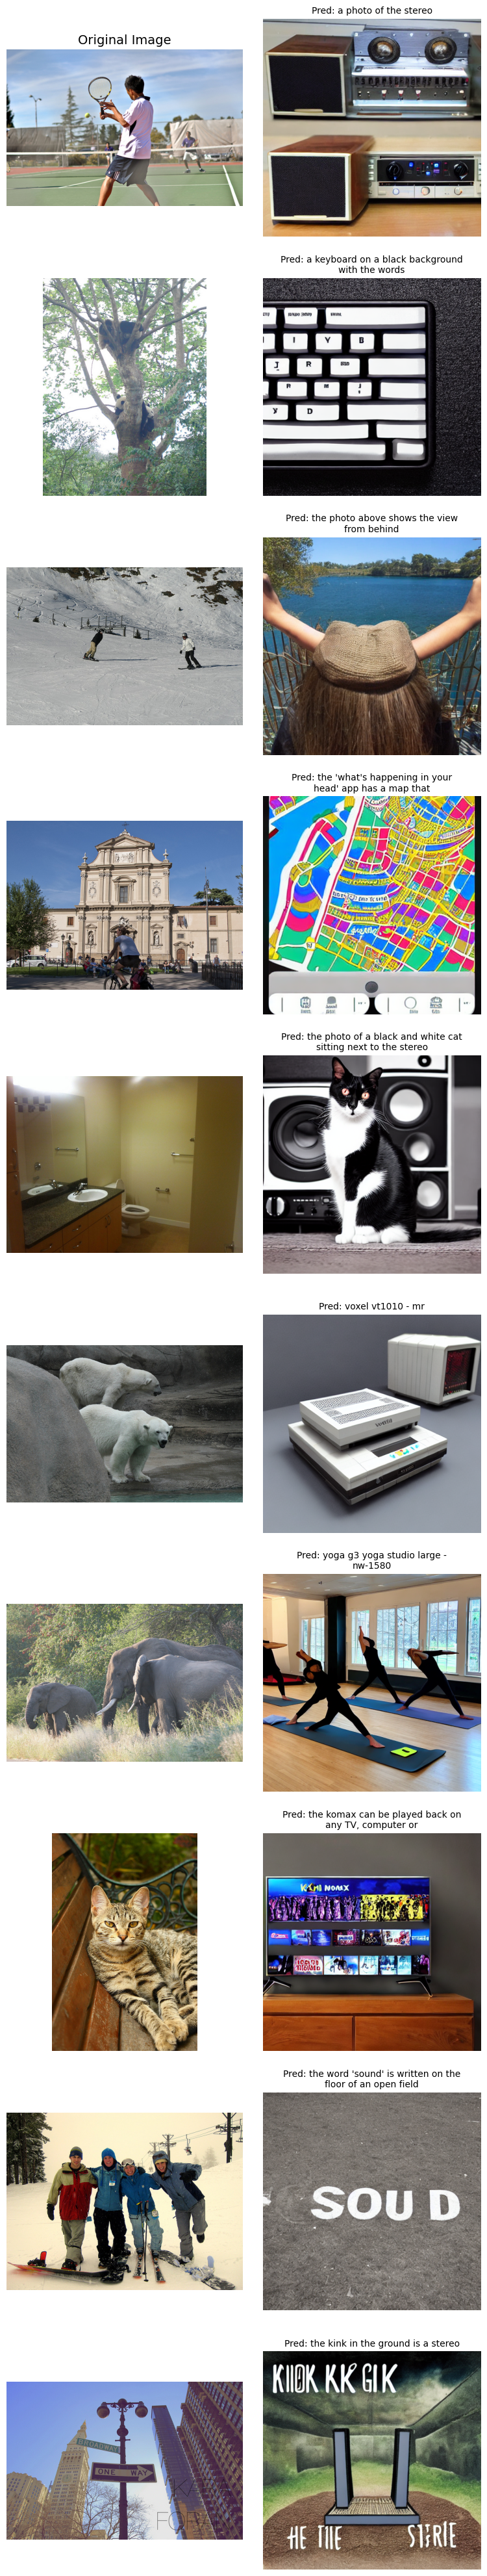

In [4]:
if __name__ == '__main__':
    # Make sure to copy your class definitions for the models above!
    config = INFERENCE_CONFIG()
    run_inference(config)

## Old Inference Script

In [5]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

# --- 1. Set up the model and pipeline ---
# This will download the model from the Hugging Face Hub the first time you run it.
model_id = "runwayml/stable-diffusion-v1-5"
# Use torch.float16 for faster inference and less memory on NVIDIA GPUs.
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Move the pipeline to the GPU for much faster generation.
# If you don't have a GPU, you can remove this line, but it will be very slow.
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)
print(f"Using device: {device}")

# --- 2. Define your text prompt ---
# This is where you'll put the caption you generated.
prompt = "the small brown dog next to the chair is a dog house a small dog kenn"

# --- 3. (Optional) Set a seed for reproducibility ---
# Using a seed ensures you get the same image every time for the same prompt.
generator = torch.Generator(device=device).manual_seed(42)

# --- 4. Generate the image ---
# The pipeline returns an object with the generated image(s).
print("Generating image...")
output = pipe(prompt=prompt, generator=generator)
image = output.images[0] # The generated image is a PIL Image object

# --- 5. Save the image ---
output_path = "generated_image.png"
image.save(output_path)
print(f"Image saved successfully to {output_path}")

# You can also display the image if you are in a Jupyter Notebook or similar environment.
# display(image)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

TypeError: StableDiffusionSafetyChecker.__init__() got an unexpected keyword argument 'offload_state_dict'